<a href="https://colab.research.google.com/github/Anant-vikram-singh/Datasets/blob/main/imageofdigitclassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import io
import warnings

#sklearn specific imports
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import hinge_loss
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate, cross_val_predict,GridSearchCV
from pprint import pprint
from sklearn.decomposition import PCA

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#global matplotlib settings
mpl.rc('figure',figsize=(8,6))
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# to make this notebook's output stable across runs
np.random.seed(42)

In [2]:
# Ignore all warnings (like convergence..) by sklearn
def warn(*args, **kwargs):
    pass
warnings.warn = warn

In [3]:
X,y= fetch_openml('mnist_784',version=1,return_X_y=True)
#it returns Data and label as a pandas dataframe


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
X = X.to_numpy()
y = y.to_numpy()

In [5]:
target_names = np.unique(y)
print('Number of samples: {0}, type:{1}'.format(X.shape[0],X.dtype))
print('Number of features: {0}'.format(X.shape[1]))
print('Minimum:{0},Maximum:{1}'.format(np.min(X),np.max(X)))
print('Number of classes: {0}, type:{1}'.format(len(target_names),y.dtype))
print('Labels: {0}'.format(target_names))

Number of samples: 70000, type:float64
Number of features: 784
Minimum:0.0,Maximum:255.0
Number of classes: 10, type:object
Labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [6]:
X = MinMaxScaler().fit_transform(X)
print("Minimum:{0},Maximum:{1}".format(np.min(X),np.max(X)))

Minimum:0.0,Maximum:1.0


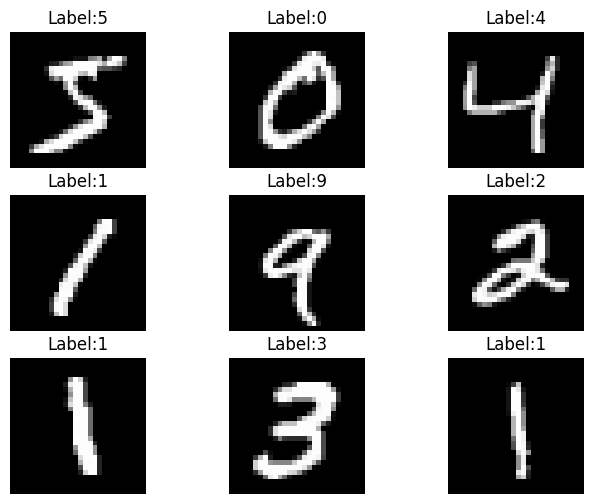

In [7]:
num_images = 9 # Choose a square number
factor = np.int(np.sqrt(num_images))
fig,ax = plt.subplots(nrows=factor,ncols=factor,figsize=(8,6))
idx_offset = 0 # take "num_images" starting from the index "idx_offset"
for i in range(factor):
  index = idx_offset+i*(factor)
  for j in range(factor):
    ax[i,j].imshow(X[index+j].reshape(28,28),cmap='gray')
    ax[i,j].set_title('Label:{0}'.format(str(y[index+j])))
    ax[i,j].set_axis_off()

In [8]:
x_train,x_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

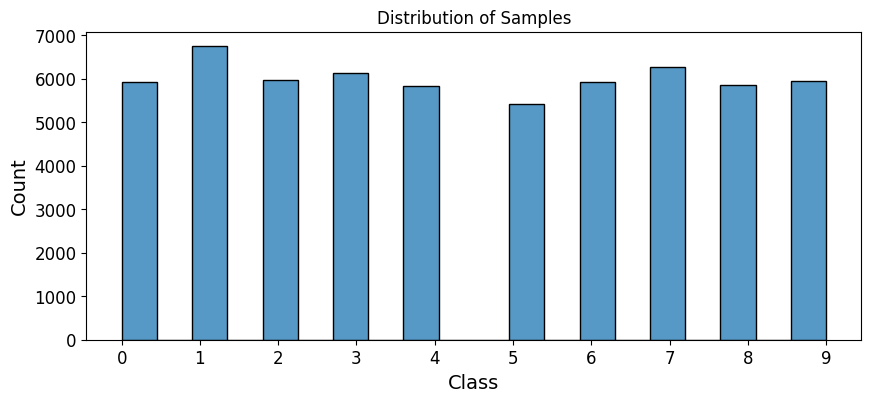

In [9]:
plt.figure(figsize=(10,4))
sns.histplot(data=np.int8(y_train),binwidth=0.45,bins=11)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9],labels=[0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Class')
plt.title('Distribution of Samples')
plt.show()

Let us start with a simple classification problem, that is, binary classification.

Since the original label vector contains 10 classes, we need to modfiy the number of classes to 2

Therefore, the label 0 will be changed to 1 and all other labels (1-9) will be changed to -1.

We name the label vectors as y_train_0 and y_test_0.

In [11]:
# intialize new variable names with all -1
y_train_0 = -1*np.ones((len(y_train)))
y_test_0 = -1*np.ones((len(y_test)))

# find indices of digit 0 image
indx_0 = np.where(y_train =='0') # remember original labels are of type str not int
# use those indices to modify y_train_0&y_test_0
y_train_0[indx_0] = 1
indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

In [12]:
print(y_train)   # 10 class labels
print(y_train_0) # modified binary labels

['5' '0' '4' ... '5' '6' '8']
[-1.  1. -1. ... -1. -1. -1.]


In [13]:
print(np.where(y_train=='0')) # index of label 0's in original vector y
print(np.where(y_train_0 == 1)) # index of pos class in new vector

(array([    1,    21,    34, ..., 59952, 59972, 59987]),)
(array([    1,    21,    34, ..., 59952, 59972, 59987]),)


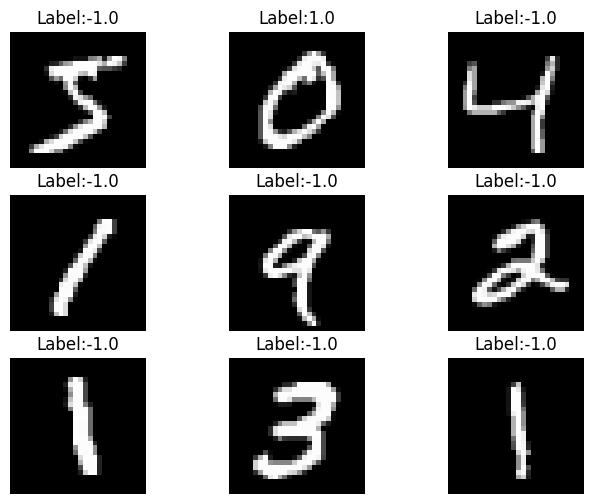

In [14]:
num_images = 9 # Choose a square number
factor = np.int(np.sqrt(num_images))
fig,ax = plt.subplots(nrows=factor,ncols=factor,figsize=(8,6))
idx_offset = 0 # take "num_images" starting from the index "idx_offset"
for i in range(factor):
  index = idx_offset+i*(factor)
  for j in range(factor):
    ax[i,j].imshow(X[index+j].reshape(28,28),cmap='gray')
    ax[i,j].set_title('Label:{0}'.format(str(y_train_0[index+j])))
    ax[i,j].set_axis_off()

In [15]:
num_pos = len(np.where(y_train_0==1)[0])
num_neg = len(np.where(y_train_0==-1)[0])
print(num_pos,num_neg)

5923 54077


In [16]:
base_clf = DummyClassifier(strategy='most_frequent') # there are other strategies

In [17]:
base_clf.fit(x_train,y_train_0)
print('Training accuracy:{0:.2f}'.format(base_clf.score(x_train,y_train_0)))
print('Testing accuracy:{0:.2f}'.format(base_clf.score(x_test,y_test_0)))

Training accuracy:0.90
Testing accuracy:0.90


In [18]:
bin_clf = Perceptron(max_iter=100,random_state=1729)

In [19]:
bin_clf.fit(x_train,y_train_0)
print('Dimention of Weights w: {0}'.format(bin_clf.coef_.shape))
print('Bias :{0}'.format(bin_clf.intercept_))
print('The loss function: {0}'.format(bin_clf.loss_function_))

Dimention of Weights w: (1, 784)
Bias :[-108.]
The loss function: <sklearn.linear_model._sgd_fast.Hinge object at 0x7f915c786dd0>


In [20]:
y_hat_train_0 = bin_clf.predict(x_train)
print('Training Accuracy: ',bin_clf.score(x_train,y_train_0))

Training Accuracy:  0.99095


In [21]:
print('Test accuracy: ',bin_clf.score(x_test,y_test_0))

Test accuracy:  0.989


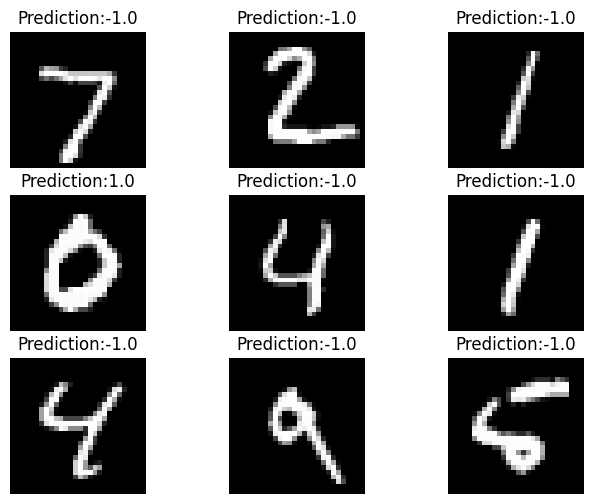

In [22]:
y_hat_test_0 = bin_clf.predict(x_test)
num_images = 9 # Choose a square number
factor = np.int(np.sqrt(num_images))
fig,ax = plt.subplots(nrows=factor,ncols=factor,figsize=(8,6))
idx_offset = 0 # display "num_images" starting from idx_offset
for i in range(factor):
  index = idx_offset+i*(factor)
  for j in range(factor):
    ax[i,j].imshow(x_test[index+j].reshape(28,28),cmap='gray') # we should not use x_train_with_dummy
    ax[i,j].set_title('Prediction:{0}'.format(str(y_hat_test_0[index+j])))
    ax[i,j].set_axis_off()

In [23]:
indx_0 = np.where(y_test_0 == 1)

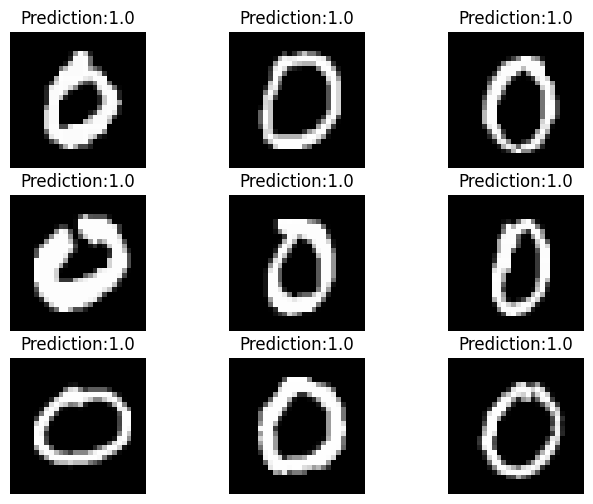

In [24]:
zeroImgs = x_test[indx_0[0]]
zeroLabls = y_hat_test_0[indx_0[0]]
num_images = 9 # Choose a square number
factor = np.int(np.sqrt(num_images))
fig,ax = plt.subplots(nrows=factor,ncols=factor,figsize=(8,6))
idx_offset = 0 # display "num_images" starting from idx_offset
for i in range(factor):
  index = idx_offset+i*(factor)
  for j in range(factor):
    ax[i,j].imshow(zeroImgs[index+j].reshape(28,28),cmap='gray') # we should not use x_train_with_dummy
    ax[i,j].set_title('Prediction:{0}'.format(str(zeroLabls[index+j])))
    ax[i,j].set_axis_off()

In [25]:
num_misclassified = np.count_nonzero(zeroLabls== -1)
num_correctpred = len(zeroLabls)-num_misclassified
accuracy = num_correctpred/len(zeroLabls)
print(accuracy)

0.9193877551020408


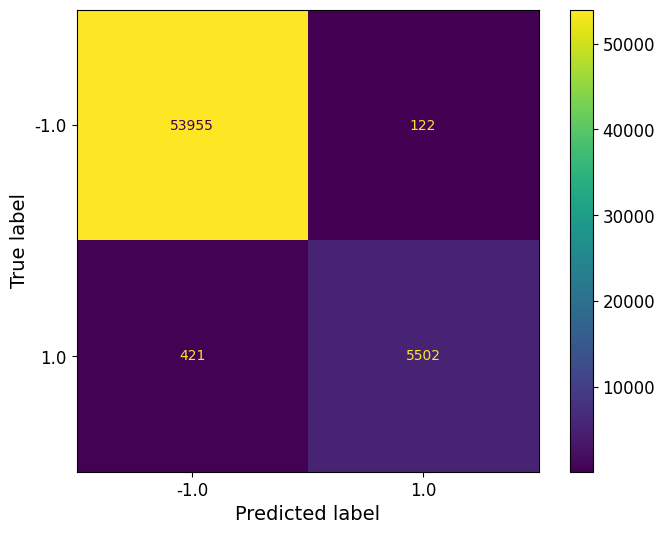

In [26]:
y_hat_train_0 = bin_clf.predict(x_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0,y_hat_train_0,values_format='.5g') # it return matplotlin plot object
plt.show()

In [27]:
bin_clf = Perceptron(max_iter=100,random_state=1729) # repeating for readability
scores= cross_validate(bin_clf, x_train, y_train_0, cv=5,
                       scoring=['precision','recall','f1'],
                       return_estimator=True)
pprint(scores)

{'estimator': [Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729)],
 'fit_time': array([0.64940953, 1.3083992 , 0.89229727, 0.83608389, 1.0414927 ]),
 'score_time': array([0.03260899, 0.03123665, 0.03270459, 0.03240776, 0.03335857]),
 'test_f1': array([0.95238095, 0.91666667, 0.94915254, 0.94117647, 0.95091763]),
 'test_precision': array([0.95890411, 0.98828125, 0.95319149, 0.95090439, 0.96200345]),
 'test_recall': array([0.94594595, 0.85472973, 0.94514768, 0.93164557, 0.94008439])}


In [28]:
print('f1,        avg:{0:.2f}, std:{1:.3f}'.format(scores['test_f1'].mean(),scores['test_f1'].std()))
print('precision, avg:{0:.2f}, std:{1:.2f}'.format(scores['test_precision'].mean(),scores['test_precision'].std()))
print('recall,    avg:{0:.2f}, std:{1:.2f}'.format(scores['test_recall'].mean(),scores['test_recall'].std()))

f1,        avg:0.94, std:0.013
precision, avg:0.96, std:0.01
recall,    avg:0.92, std:0.03


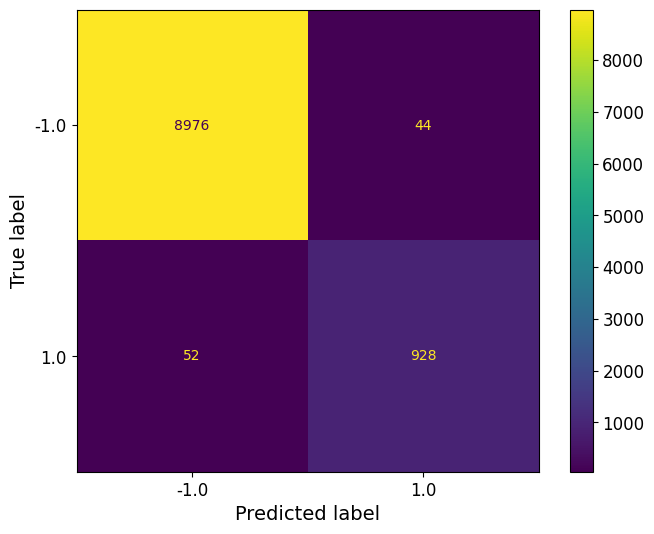

In [29]:
bin_clf = scores['estimator'][0]
y_hat_test_0 = bin_clf.predict(x_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0,y_hat_test_0,values_format='.5g') # it return matplotlin plot object


In [30]:
print('Precision %.2f'%precision_score(y_test_0,y_hat_test_0))
print('Recall %.2f'%recall_score(y_test_0,y_hat_test_0))

Precision 0.95
Recall 0.95
